# Chapter 4: Recurrent Neural Network

Now we want to develop models that can handle sequences (e.g., sequences of characters and words). We can also try to predict the temprature using sequence of temprature per hour.

Unlike the previous problem, the structure in this case is quite different. Sequences can have a *variable* number of items in each sequence. For example, the two previous sentences have variable lenght 19 and 11 words respectively. Whereas, images size are always the same. If not we can just resize it without changing the meaning. However, in sequence, that is not the case. "Resizing" sequences changes its meaning.

For this reason, we are using the Recurrent Neural Network (RNN). RNN are  particularly useful because they are able to handle inputs with differing sequence lengths.

When talking about RNNs, we will often reer to the sequence as a "time series" and the *i*th item in the sequence as the *i*th "step in time". We are going to use *t* and *i* to denote a specific item/point in time. We will also use *T* to refer to the number of items in the input sequence. For example *T=19* refers to the 19 words in the first sentence.

RNN takes sequence as input and produces new sequence as output.

## Reccurent Neural Networks as Weight Sharing

Before going deep to RNN, let's refresh the previous topic regarding "weight sharing". The figure below will help you refresh the concept.

<img src="https://drive.google.com/uc?export=view&id=1atSVJVO2mUX8cAfXyjZGZ6xnHRoiDx1y" alt="drawing" width="600"/>

When using a CNN, the convolution operation is like having a single small linear network that we slide across the image, applying the same function to every spatial position. This is an implicit property of a CNN, that we made explicit with this small bit of code.

```python
    # Some input vector
    x = torch.rand(D)
    # Expected out vector after applying filter with size K to input D
    output = torch.zeros(D-K//2*2)
    for i in range(output.shape[0]):
        output[i] = f(x[i:i+K], theta)
```

The above code shows the idea of weight sharing, re-using the same weights $\Theta$ for multiple inputs. Understanding the weight sharing mechanism will help us to arrive at the original RNN algorithm.

### Weight Sharing

To start, let's assume that we want to create a fully connected network with 3 hidden layers for classification problem.

<img src="https://drive.google.com/uc?export=view&id=1CN-m7RZgpbsPLmqvVySdw6LpBkhdm3Iy" alt="drawing" width="600"/>

Which in math notation can be denoted as:
$$f(x)=tanh\left(tanh\left(tanh\left(x^T W_{d \times n}^{h1}\right) W_{n \times n}^{h2}\right) W_{n \times n}^{h3}\right) W_{n \times classes}^{out}$$

From the equations above, it shows that we have *d* input feature, *n* neurons in each hidden layer, and *classes* output. Below is the implementation of the network on the MNIST data.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import BatchSampler
from idlmam import *
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

import pandas as pd
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pprint

In [2]:
# Check and decide device to be used
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

mnist_data_train = torchvision.datasets.MNIST('./data', train=True, download=True,
transform=transforms.ToTensor())

mnist_data_test = torchvision.datasets.MNIST('./data', train=False, download=True,
transform=transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_data_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=64)

'''
    How many values are in the input? 
    We use this to help determine the 
    size of subsequent layers
'''

# 28 * 28 images
D = 28*28 

# Hidden layer size
n = 256

# Number of channel
C = 1

# Number of classes/total predictions
classes = 10

# Model
model_regular = nn.Sequential(
    Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [3]:
loss_func = nn.CrossEntropyLoss()
regular_results = train_simple_network(model_regular, loss_func, mnist_train_loader,
test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score},
device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Let's say that this is a very large network and we cannot fit the weight for all three hidden layers. One option is to share the weights between some layers. From the picture above notice that $h_2$ and $h_3$ have the same input output. Hence, we can share the weight by simply replacing $h_2$ with $h_3$.

Which in math notation can be denoted as:
$$f(x)=tanh\left(tanh\left(tanh\left(x^T W_{d \times n}^{h1}\right) W_{n \times n}^{h2}\right) W_{n \times n}^{h2}\right) W_{n \times classes}^{out}$$

The code below shows the weight sharing network.

In [4]:
#Create the layer of weights of our network that we plan to share.
h_2 = nn.Linear(n, n)

model_shared = nn.Sequential(
    Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    # First use
    h_2,
    nn.Tanh(),
    # Second use
    h_2,
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [5]:
shared_results = train_simple_network(model_shared, loss_func, mnist_train_loader,
test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score},
device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

With the new weight-shared network, we can now plot the validation accuracy of both to see what that 1) PyTorch really learn with shared weights, and 2) what the results look like.

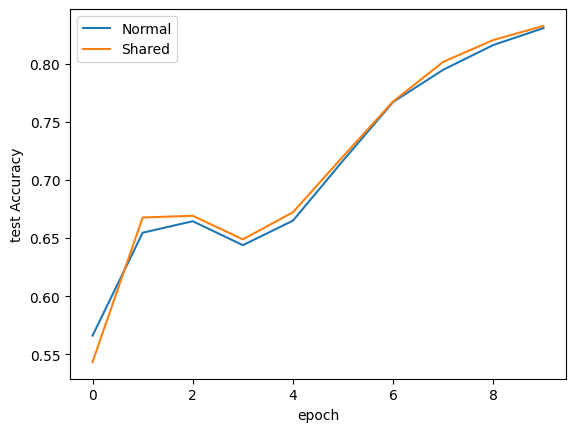

In [6]:
#Now we can plot the results, and compare them
sns.lineplot(x='epoch', y='test Accuracy', data=regular_results, label='Normal')
sns.lineplot(x='epoch', y='test Accuracy', data=shared_results, label='Shared')
plt.show()

As can be seen from the figure above, weight sharing didn't take a longer time to train, nor it lose any accuracy. We only get a benefit of slightly reduced memory usage. However, the main point in weight sharing in this chapter is to learn about the foundation in creating and training RNN.

### Weight Sharing Over Time

Now that we understand weight sharing, we can start using it to create RNNs. The goal of an RNN is to summarize every item that was seen in a sequence of items, using just a single item. The process can be seen below.

<img src="https://drive.google.com/uc?export=view&id=1_jM5gfSsrPkm-LJVx_NFZtcRSLtb723X" alt="drawing" width="400"/>

Steps:
1. a tensor $h_{t-1}$ represents everything seen so far in the order they have been seen.
2. a tensor $x_t$ represents the newest/next item in the sequence.
3. RNN takes and combines the historical summary $(h_{t-1})$ and the new information $(x_t)$ to create new summary of everything we have seen thus far $(h_t)$.

If we want to make a prediction about the entire sequence of $T$ items, we would use the output after $T$ inputs $(h_T)$ because it represents the $T$'th item and every preceding item.

Lets put it into mathematical notation. Suppose we have $T$ total units of time. Instead of having single input $x \in {\rm I\!R}$, we will have $T$ inputs $x_1, x_2, ..., x_{T-1}, x_T$. Each input is a vector of the same size which is a representation of something that is sequential. For example, the weather could have a vector with the high, low, and average temperature each day $(x_t=[high, low, mean])$ in natural order.

To process it over time, we have module $A$, where $A(x) = h$. We could use weight sharing to apply the network module $A$ to every item independently. So, we would get $T$ outputs, $h_i=A(x_i)$. We will eventually use one of these output $h$ as the input to a linear layer, but first we need to work our way to an RNN. A naive approach of applying $A(\cdot)$ independently is shown in the picture below.

<img src="https://drive.google.com/uc?export=view&id=1xGg3oHKAPF_5v5YF-Qiom4yInv2qkSqO" alt="drawing" width="600"/>


From the process above, we used the same function/layer $A(\cdot)$ to apply weight sharing to each item over time. However, we have not done anything to connect the information over time. We need our function to take both history and the input, which in code will look like this:

```python
# h0
history_summary = 0 

# x1, x2, . . . , xT
inputs = [...] 

for t in range(T):
    # ht = A(ht−1, xt)
    new_summary = RNN(history_summary, inputs[t]) 
    history_summary = new_summary
```

This can be done by giving $A$ a *recurrent weight*. We've used $h_t$ to indicate the result from time step $t$. First lets look at the equation with some light annotation,

$$\overbrace{h_t}^{new summary} = 
A(\overbrace{h_{t-1}}^{history summary}, \overbrace{x_t}^{new item}) = 
tanh \left(
\overbrace{h_{t-1}^{T}W_{n \times n}^{prev}}^{update history summary}  +
\overbrace{x_{t}^{T}W_{d \times n}^{cur}}^{incorporate new information}
\right)$$

, where:

$h_t$,is a current vector of a summary of all $t$ items that have been seen so far.

$A()$, an RNN module to make the summary (takes two parameters).

$h_{t-1}$, a summary of everything previous seen.

$x_t$, the $t$'th new item.

$tanh()$, a non liniearity that is applied after the inside operation is done, outputing the new summary $h_t$.

$h_{t-1}^{T}W_{n \times n}^{prev}$, a linear layer that processes the previous history

$+$, mixing them together

$x_{t}^{T}W_{d \times n}^{cur}$, a second linear layer that proesses the new input.

So, we have one set of weights ($W_{d \times n}^{cur}$) that takes in the current time step ($x_i$) that are added to second set of weights ($W_{n \times n}^{prev}$) for the previous time step's result ($h_{i-1}$). By reusing this new function for each time step, we get information accross time.This can be seen from the picture below.

<img src="https://drive.google.com/uc?export=view&id=1Ng0NIBBhnPhQ_pITK6Mkb70swiq57bey" alt="drawing" width="600"/>

The overall idea of RNN is to re-use the same function and weights at every time step. At time step t, the model gets information about the past from the hidden state $h_{t-1}$. Because $h_{t-1}$ was computed from h_{t-2}, it actually has information from the past two time steps, and so on.

But what do we do at the start of time (i=1) when $h_0$ does not exist? Implicitly we assume that $h_0 = \vec{0}$ (i.e., a vector of all zeros). This is shown in the figure below, where $T = 3$.

<img src="https://drive.google.com/uc?export=view&id=1Imm1QbNZJJ0GqZ6kGSzTIgHgXQ20RIdI" alt="drawing" width="600"/>

For simple classification, we will use the last $h_T$ to make prediction as it contains all of the previous information.


## RNNs in PyTorch

Overview of RNN steps:

<img src="https://drive.google.com/uc?export=view&id=1UoplP2FDXKIaea4hb_yAajTYyc1rE9IN" alt="drawing" width="600"/>

To represent sequence data for an RNN in PyTorch, we will use a 3D input representation, 

$$(B, T, D)$$

, where $B$ is batch size, $T$ total number of time steps, and $D$ is the number of features per time step.

### A Simple Sequence Classification Problem

Let's start with many-to-one classification problem (many inputs (every time step) and one ouput).

For this task, let's try to predict the language a name come from (e.g., Steven would be an English name, etc).

<img src="https://drive.google.com/uc?export=view&id=11_MxwJ55DNwOu6YgP4p_QmO5ryxbqIBd" alt="drawing" width="600"/>

In [7]:
# Download dataset
import requests, zipfile, io

# Zip file is organized as data/names/[LANG].txt , 
# where [LANG] is a specific language
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))

z.extractall()

In [8]:
#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

name_language_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}

for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Loop through every language, 
# open the zip file entry, 
# and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(),
                        encoding='utf-8').strip().split("\n")]
            name_language_data[lang] = lang_names
            print(lang, ": ", len(lang_names)) 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


Now, with our data loaded in memory, we can implement a $Dataset$ to represent it. The $data$ list will contain each name, and an associated index in the $labels$ list will indicate which specific language the name come from. A $vocabulary$ dictionary will map every unique item to an integer value.

In [9]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
                
    def __len__(self):
        '''
        return the total number of data points within the dataset
        '''
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, 
        according to the vocabulary used by this object.
        tensor len = char len
        input_string: the string to convert to a tensor
        """
        # number of characters in a string
        T = len(input_string)
        
        # Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        
        # Iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        '''
        return:
        tensor representation of the character and its label
        (tensor([10, 7, 14, 20, 17, 24]), 0)
        '''
        # Original string
        name = self.data[idx]
        label = self.labels[idx]
        
        # Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        return self.string2InputVec(name), label

In [10]:
# Create train/test split with 300 items in test split.
dataset = LanguageNameDataset(name_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

### Embedding Layers

Now that the dataset is loaded, we can talk about the remaining parts of our RNN.

First, we need to implement our $Dataset$ class such that it returns a tensor of length $T$ (the number of characters in a name) storing integer values (a unique value for every character). For example, "a" becomes 0, "b" becomes 1, etc. This is what we can achieve using the <code> string2InputVec() </code> and mapping from <code> vocabulary </code> dictionary.

Next, we need to create an $embedding$ layer. This layers are lookup tables designed to map each integer value to a specific vector representation. In here you need to tell the embedding layer how large the vocabulary is (i.e, how many unique items exist) and how large the dimension you want it to be. the figure below shows the overview of the embedding layer.

<img src="https://drive.google.com/uc?export=view&id=1RAmUxhABWPvRtK9cA8HLLnxFjYJh5_CV" alt="drawing" width="600"/>

In the example, the vocabulary contains both characters and words. The vocabulary does not even need to be a string so long that it is consistently mapped to an integer value. The <code> nn.Embedding </code> function's first argument is $5$ to indicate that the vocab has five unique items. The second argument $3$ is the output dimension. You can thing of this as similar as the <code> nn.Linear </code> layer.

We could increase or decrease the output size based on how much information we
think the model needs to be able to pack into each vector. In most applications, you will want to try values in the range of [64, 256] for the number of output dimensions.

The nn.Embedding layer is designed to work with sequences of things. That means it's possible for the sequence to contain repetitions. For example, the below code snippet creates a new input sequence with $T=5$ items in it, but a vocabulary of only 3 items. This is OK because the input sequence [0, 1, 1, 0, 2] has repetitions (0 and 1 occur twice). The embedding object is created with a dimension of d=2, and processes the input to create a new
representation x_seq.

In [11]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[-1.8400,  0.0152],
        [ 1.8229, -0.6469],
        [ 1.8229, -0.6469],
        [-1.8400,  0.0152],
        [ 0.3028,  0.3337]])


This <code> x_seq </code> would be the tensor representation that is now compatible with all of the standard tools of deep learning. Notice that its shape is now (5, 2), and you will see random values filled in. Thats because the Embedding layer initializes everything to random, and these values are altered by gradient descent as the network is trained. 

Notice that the 1st and 4th rows of the matrix have the exact same values, as do the 2nd and 3rd. This is because the order in the output matches the order in the input.

When working with strings, or any other content that does not naturally exist as "vectors", you will almost always want to use an Embedding layer as your first step. This is the standard tool for converting these abstract concepts to representations we can work with.

### Last Time Step

PyTorch has provide the standard RNN algo. What's left is to extract the last time step $h_T$ after being processed by the RNN. We want to do this because the last time step is the only one that carries information from all T inputs based on the input's order.

$h_T$ will have the same shape and size, no matter how long the
input sequence is. So if our RNN layer has 64 neurons, $h_T$ will be a 64-dimension vector represented as a tensor of shape (B, 64). It does not matter if our sequence has one item T=1, or T=100 items, it will always be the case that $h_T$ will have shape (B, 64).

<img src="https://drive.google.com/uc?export=view&id=1Fjx7mRz_P4Q27E0Qv_Tr-PpHivs81bm1" alt="drawing" width="600"/>

Now, we need to implement a new model that extracts the last time step before we can specify an RNN architecture in PyTorch. There are two things that we need to know: the number of layers, and if the model was bidirectorial. This is because the RNN will return enough information for us to extract the result from any layer, giving us the flexibility to implement other kinds of models that will be discussed further in the book.

Below is the code that does the work o extract the $LastTimeStep$ $h_T$ from an RNN. Depending the RNN used, the output of an RNN Module is a tuple of two tensors or a nested tuple of three tensors, with the last time step's activation stored in the second item of the tuple.

In [12]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1
            
    def forward(self, input):
        # Result is either a tuple (out, h_t)
        # or a tuple (out, (h_t, c_t))
        
        rnn_output = input[0]
        
        # h_t
        last_step = input[1] 
        
        # Unless it's a tuple,
        if(type(last_step) == tuple):
            # Then h_t is the first item in the tuple
            last_step = last_step[0]
        
        # Per docs, shape is: 
        # '(num_layers, num_directions, batch, hidden_size)'
        batch_size = last_step.shape[1]
        
        # Reshaping so that everything is separated
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        
        # We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

The output of an RNN in PyTorch is a tuple of shape $(out, H_T)$ or $(out, (h_T, c_T))$. The $out$ object has information about every time step, and $h_T$ contains information about only the last time step but for every layer.

Once we have $h_T$, PyTorch is going to provide it as an input that has been $flatten()$-ed. we can use $view$ function to re-shape the tensor with information about the layers, bidirectional content, the batch size, and the number of neurons $d$ in the hidden layer. Since, we want the last layer's result, we can index in and then use the $permute$ function to move the batch dimension to the front.

The code below is the final step needed to complete the RNN.

In [13]:
# Size of embedding result (vector representation dimension)
D = 64

# length of all characters and symbols
vocab_size = len(all_letters)

# Number of neurons in RNN
hidden_nodes = 256

# Number of classes/predictions
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
    #(B, T) -> (B, T, D)
    nn.Embedding(vocab_size, D), 
    #(B, T, D) -> ( (B,T,D) , (S, B, D) )
    nn.RNN(D, hidden_nodes, batch_first=True), 
    # The tanh activation is built into the RNN object, 
    # so we don't need to do it here
    # We need to take the RNN output and reduce it to one item, (B, D)
    LastTimeStep(), 
    #(B, D) -> (B, classes)
    nn.Linear(hidden_nodes, classes), 
)

Explanations:
The input batch is processing $B$ items with a length of up to $T$, so the input has a shape of $(B, T)$. The nn.Embedding layer converts this to a shape of $(B, T, D)$ - adding the D dimensions from the embedding.

The RNN takes inputs of shape (B, T, D) only if we specify that <code>batch_first=True</code>.

The RNN will return a tuple of at least two tensors, but our $LastTimeStep$ module is designed to take this in and return a fixed length vector by extracting $h_T$ from the last time step. Since $h_T \in {\rm I\!R}^D$ and we are processing $B$ items in a batch, that gives us a tensor of shape $(B, D)$. This is the same shape that our fully-connected networks expect. That means
we can now just use standard fully-connected layers. In this case, we can use just one to create a linear layer that makes the final prediction. With that, we can again use the <code>train_simple_network</code> function to train our first RNN.

In [ ]:
loss_func = nn.CrossEntropyLoss()

batch_one_train = train_simple_network(first_rnn, loss_func, train_loader,
                test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
                epochs=5)

sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')
plt.show()

In [ ]:
pred_rnn = first_rnn.to("cpu").eval()

with torch.no_grad():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

For further information read Inside Deep Learning: Math, ALgorithms, Models (MEAP) V05 page 138 - 150